In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : False,
    'huntington'    : True,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : [],
    'outp'          : 'diffusion_md',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_0_t1t2_normalized_e_e_e_1_1_e_1_0_diffusion_md_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(663976, 919)
(663976, 1)
validation
(128936, 919)
(128936, 1)
test
(61376, 919)
(61376, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 919)]             0         


 dense (Dense)               (None, 1024)              942080    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1631233 (6.22 MB)


Trainable params: 1631233 (6.22 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/67 [..............................] - ETA: 1:21 - loss: 0.0396 - STD: 2.0578e-04 - MAE: 0.1891

 4/67 [>.............................] - ETA: 1s - loss: 0.0269 - STD: 2.2848e-04 - MAE: 0.1225  

 7/67 [==>...........................] - ETA: 1s - loss: 0.0244 - STD: 2.1187e-04 - MAE: 0.1099

10/67 [===>..........................] - ETA: 1s - loss: 0.0216 - STD: 2.6918e-04 - MAE: 0.1044

13/67 [====>.........................] - ETA: 1s - loss: 0.0206 - STD: 3.2756e-04 - MAE: 0.1060

16/67 [======>.......................] - ETA: 0s - loss: 0.0193 - STD: 3.6866e-04 - MAE: 0.1002

19/67 [=======>......................] - ETA: 0s - loss: 0.0188 - STD: 3.9842e-04 - MAE: 0.0954

21/67 [========>.....................] - ETA: 2s - loss: 0.0185 - STD: 4.2025e-04 - MAE: 0.0929

24/67 [=========>....................] - ETA: 1s - loss: 0.0179 - STD: 4.6295e-04 - MAE: 0.0905

27/67 [===========>..................] - ETA: 1s - loss: 0.0175 - STD: 5.1323e-04 - MAE: 0.0903

30/67 [============>.................] - ETA: 1s - loss: 0.0171 - STD: 5.6489e-04 - MAE: 0.0898

33/67 [=============>................] - ETA: 1s - loss: 0.0168 - STD: 6.1436e-04 - MAE: 0.0883

36/67 [===============>..............] - ETA: 1s - loss: 0.0166 - STD: 6.6750e-04 - MAE: 0.0866

39/67 [================>.............] - ETA: 0s - loss: 0.0164 - STD: 7.3193e-04 - MAE: 0.0855

42/67 [=================>............] - ETA: 0s - loss: 0.0162 - STD: 8.1335e-04 - MAE: 0.0851

45/67 [===================>..........] - ETA: 0s - loss: 0.0160 - STD: 9.0884e-04 - MAE: 0.0848

48/67 [====================>.........] - ETA: 0s - loss: 0.0158 - STD: 0.0010 - MAE: 0.0842    

51/67 [=====================>........] - ETA: 0s - loss: 0.0157 - STD: 0.0011 - MAE: 0.0834

54/67 [=======================>......] - ETA: 0s - loss: 0.0156 - STD: 0.0013 - MAE: 0.0829

57/67 [========================>.....] - ETA: 0s - loss: 0.0154 - STD: 0.0015 - MAE: 0.0825

60/67 [=========================>....] - ETA: 0s - loss: 0.0153 - STD: 0.0018 - MAE: 0.0822

63/67 [===========================>..] - ETA: 0s - loss: 0.0152 - STD: 0.0021 - MAE: 0.0816

66/67 [============================>.] - ETA: 0s - loss: 0.0150 - STD: 0.0025 - MAE: 0.0810

67/67 [==============================] - 4s 39ms/step - loss: 0.0150 - STD: 0.0027 - MAE: 0.0809 - val_loss: 0.0126 - val_STD: 0.0109 - val_MAE: 0.0684


Epoch 2/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0118 - STD: 0.0153 - MAE: 0.0712

 4/67 [>.............................] - ETA: 1s - loss: 0.0115 - STD: 0.0181 - MAE: 0.0704

 7/67 [==>...........................] - ETA: 1s - loss: 0.0113 - STD: 0.0212 - MAE: 0.0683

10/67 [===>..........................] - ETA: 1s - loss: 0.0107 - STD: 0.0253 - MAE: 0.0664

13/67 [====>.........................] - ETA: 1s - loss: 0.0103 - STD: 0.0302 - MAE: 0.0650

16/67 [======>.......................] - ETA: 1s - loss: 0.0098 - STD: 0.0356 - MAE: 0.0635

19/67 [=======>......................] - ETA: 0s - loss: 0.0093 - STD: 0.0410 - MAE: 0.0621

22/67 [========>.....................] - ETA: 0s - loss: 0.0089 - STD: 0.0459 - MAE: 0.0608

25/67 [==========>...................] - ETA: 0s - loss: 0.0085 - STD: 0.0502 - MAE: 0.0595

28/67 [===========>..................] - ETA: 0s - loss: 0.0082 - STD: 0.0538 - MAE: 0.0584

31/67 [============>.................] - ETA: 0s - loss: 0.0079 - STD: 0.0572 - MAE: 0.0574

34/67 [==============>...............] - ETA: 0s - loss: 0.0076 - STD: 0.0602 - MAE: 0.0565

36/67 [===============>..............] - ETA: 0s - loss: 0.0075 - STD: 0.0623 - MAE: 0.0560

39/67 [================>.............] - ETA: 0s - loss: 0.0073 - STD: 0.0647 - MAE: 0.0553

42/67 [=================>............] - ETA: 0s - loss: 0.0071 - STD: 0.0669 - MAE: 0.0546

45/67 [===================>..........] - ETA: 0s - loss: 0.0070 - STD: 0.0686 - MAE: 0.0540

48/67 [====================>.........] - ETA: 0s - loss: 0.0068 - STD: 0.0703 - MAE: 0.0534

51/67 [=====================>........] - ETA: 0s - loss: 0.0067 - STD: 0.0718 - MAE: 0.0529

54/67 [=======================>......] - ETA: 0s - loss: 0.0065 - STD: 0.0731 - MAE: 0.0524

57/67 [========================>.....] - ETA: 0s - loss: 0.0064 - STD: 0.0743 - MAE: 0.0520

60/67 [=========================>....] - ETA: 0s - loss: 0.0063 - STD: 0.0755 - MAE: 0.0515

63/67 [===========================>..] - ETA: 0s - loss: 0.0062 - STD: 0.0764 - MAE: 0.0510

66/67 [============================>.] - ETA: 0s - loss: 0.0061 - STD: 0.0773 - MAE: 0.0507

67/67 [==============================] - 2s 26ms/step - loss: 0.0060 - STD: 0.0776 - MAE: 0.0505 - val_loss: 0.0035 - val_STD: 0.0822 - val_MAE: 0.0396


Epoch 3/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0992 - MAE: 0.0417

 4/67 [>.............................] - ETA: 1s - loss: 0.0036 - STD: 0.0973 - MAE: 0.0411

 7/67 [==>...........................] - ETA: 1s - loss: 0.0037 - STD: 0.0967 - MAE: 0.0411

10/67 [===>..........................] - ETA: 1s - loss: 0.0036 - STD: 0.0972 - MAE: 0.0410

13/67 [====>.........................] - ETA: 1s - loss: 0.0036 - STD: 0.0976 - MAE: 0.0408

16/67 [======>.......................] - ETA: 1s - loss: 0.0036 - STD: 0.0980 - MAE: 0.0408

19/67 [=======>......................] - ETA: 1s - loss: 0.0036 - STD: 0.0984 - MAE: 0.0406

22/67 [========>.....................] - ETA: 0s - loss: 0.0036 - STD: 0.0989 - MAE: 0.0406

25/67 [==========>...................] - ETA: 0s - loss: 0.0036 - STD: 0.0992 - MAE: 0.0404

28/67 [===========>..................] - ETA: 0s - loss: 0.0036 - STD: 0.0990 - MAE: 0.0403

31/67 [============>.................] - ETA: 0s - loss: 0.0035 - STD: 0.0989 - MAE: 0.0401

34/67 [==============>...............] - ETA: 0s - loss: 0.0035 - STD: 0.0991 - MAE: 0.0400

37/67 [===============>..............] - ETA: 0s - loss: 0.0035 - STD: 0.0993 - MAE: 0.0400

40/67 [================>.............] - ETA: 0s - loss: 0.0035 - STD: 0.0997 - MAE: 0.0399

43/67 [==================>...........] - ETA: 0s - loss: 0.0035 - STD: 0.0998 - MAE: 0.0398

46/67 [===================>..........] - ETA: 0s - loss: 0.0035 - STD: 0.0997 - MAE: 0.0397

49/67 [====================>.........] - ETA: 0s - loss: 0.0035 - STD: 0.0998 - MAE: 0.0396

52/67 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0999 - MAE: 0.0395

55/67 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.1000 - MAE: 0.0394

58/67 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0999 - MAE: 0.0393

61/67 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.1001 - MAE: 0.0392

64/67 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.1001 - MAE: 0.0391

67/67 [==============================] - 2s 25ms/step - loss: 0.0034 - STD: 0.1001 - MAE: 0.0390 - val_loss: 0.0030 - val_STD: 0.0859 - val_MAE: 0.0365


Epoch 4/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.1036 - MAE: 0.0365

 4/67 [>.............................] - ETA: 1s - loss: 0.0031 - STD: 0.1021 - MAE: 0.0368

 7/67 [==>...........................] - ETA: 1s - loss: 0.0030 - STD: 0.1019 - MAE: 0.0366

10/67 [===>..........................] - ETA: 1s - loss: 0.0030 - STD: 0.1015 - MAE: 0.0367

13/67 [====>.........................] - ETA: 1s - loss: 0.0030 - STD: 0.1015 - MAE: 0.0366

16/67 [======>.......................] - ETA: 1s - loss: 0.0030 - STD: 0.1020 - MAE: 0.0365

19/67 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.1019 - MAE: 0.0365

22/67 [========>.....................] - ETA: 0s - loss: 0.0030 - STD: 0.1020 - MAE: 0.0364

25/67 [==========>...................] - ETA: 0s - loss: 0.0030 - STD: 0.1018 - MAE: 0.0363

28/67 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.1019 - MAE: 0.0363

31/67 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.1022 - MAE: 0.0363

34/67 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.1022 - MAE: 0.0362

37/67 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0362

40/67 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0362

43/67 [==================>...........] - ETA: 0s - loss: 0.0030 - STD: 0.1024 - MAE: 0.0362

46/67 [===================>..........] - ETA: 0s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0362

49/67 [====================>.........] - ETA: 0s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0361

52/67 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.1026 - MAE: 0.0361

55/67 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.1025 - MAE: 0.0361

58/67 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.1027 - MAE: 0.0361

61/67 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1028 - MAE: 0.0360

64/67 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1028 - MAE: 0.0360

67/67 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1029 - MAE: 0.0360

67/67 [==============================] - 2s 25ms/step - loss: 0.0029 - STD: 0.1029 - MAE: 0.0360 - val_loss: 0.0031 - val_STD: 0.0879 - val_MAE: 0.0366


Epoch 5/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.1048 - MAE: 0.0363

 4/67 [>.............................] - ETA: 1s - loss: 0.0029 - STD: 0.1042 - MAE: 0.0357

 7/67 [==>...........................] - ETA: 1s - loss: 0.0029 - STD: 0.1040 - MAE: 0.0361

10/67 [===>..........................] - ETA: 1s - loss: 0.0029 - STD: 0.1043 - MAE: 0.0360

13/67 [====>.........................] - ETA: 1s - loss: 0.0029 - STD: 0.1038 - MAE: 0.0364

16/67 [======>.......................] - ETA: 1s - loss: 0.0029 - STD: 0.1036 - MAE: 0.0364

19/67 [=======>......................] - ETA: 1s - loss: 0.0030 - STD: 0.1036 - MAE: 0.0365

22/67 [========>.....................] - ETA: 0s - loss: 0.0030 - STD: 0.1033 - MAE: 0.0366

25/67 [==========>...................] - ETA: 0s - loss: 0.0030 - STD: 0.1030 - MAE: 0.0367

28/67 [===========>..................] - ETA: 0s - loss: 0.0030 - STD: 0.1031 - MAE: 0.0367

31/67 [============>.................] - ETA: 0s - loss: 0.0030 - STD: 0.1032 - MAE: 0.0367

34/67 [==============>...............] - ETA: 0s - loss: 0.0030 - STD: 0.1032 - MAE: 0.0367

37/67 [===============>..............] - ETA: 0s - loss: 0.0030 - STD: 0.1036 - MAE: 0.0366

40/67 [================>.............] - ETA: 0s - loss: 0.0030 - STD: 0.1034 - MAE: 0.0365

43/67 [==================>...........] - ETA: 0s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0365

46/67 [===================>..........] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0364

49/67 [====================>.........] - ETA: 0s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0362

52/67 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0362

55/67 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0361

58/67 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0360

61/67 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.1034 - MAE: 0.0360

64/67 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0359

67/67 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.1035 - MAE: 0.0359

67/67 [==============================] - 2s 24ms/step - loss: 0.0029 - STD: 0.1035 - MAE: 0.0359 - val_loss: 0.0032 - val_STD: 0.0860 - val_MAE: 0.0374


Epoch 6/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.1032 - MAE: 0.0350

 4/67 [>.............................] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0346

 7/67 [==>...........................] - ETA: 1s - loss: 0.0027 - STD: 0.1047 - MAE: 0.0345

10/67 [===>..........................] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0346

13/67 [====>.........................] - ETA: 1s - loss: 0.0027 - STD: 0.1042 - MAE: 0.0345

16/67 [======>.......................] - ETA: 1s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0346

19/67 [=======>......................] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0345

22/67 [========>.....................] - ETA: 0s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0346

24/67 [=========>....................] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0347

27/67 [===========>..................] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0347

30/67 [============>.................] - ETA: 0s - loss: 0.0027 - STD: 0.1043 - MAE: 0.0347

33/67 [=============>................] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0348

36/67 [===============>..............] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0347

39/67 [================>.............] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0348

42/67 [=================>............] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0348

45/67 [===================>..........] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0348

48/67 [====================>.........] - ETA: 0s - loss: 0.0027 - STD: 0.1044 - MAE: 0.0347

51/67 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0347

54/67 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0347

57/67 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0347

60/67 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.1046 - MAE: 0.0347

63/67 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0347

66/67 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.1045 - MAE: 0.0346

67/67 [==============================] - 2s 25ms/step - loss: 0.0027 - STD: 0.1044 - MAE: 0.0346 - val_loss: 0.0032 - val_STD: 0.0884 - val_MAE: 0.0375


Epoch 7/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0025 - STD: 0.1059 - MAE: 0.0334

 4/67 [>.............................] - ETA: 1s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0338

 7/67 [==>...........................] - ETA: 1s - loss: 0.0026 - STD: 0.1042 - MAE: 0.0341

10/67 [===>..........................] - ETA: 1s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0342

13/67 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0341

16/67 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0342

19/67 [=======>......................] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0343

22/67 [========>.....................] - ETA: 0s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0344

25/67 [==========>...................] - ETA: 0s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0345

28/67 [===========>..................] - ETA: 0s - loss: 0.0027 - STD: 0.1049 - MAE: 0.0344

31/67 [============>.................] - ETA: 0s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0343

34/67 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0343

37/67 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0343

40/67 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0343

43/67 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0342

46/67 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0342

49/67 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0342

52/67 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1050 - MAE: 0.0342

55/67 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0342

58/67 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0342

61/67 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1049 - MAE: 0.0343

64/67 [===========================>..] - ETA: 0s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0343

67/67 [==============================] - ETA: 0s - loss: 0.0026 - STD: 0.1048 - MAE: 0.0343

67/67 [==============================] - 2s 25ms/step - loss: 0.0026 - STD: 0.1048 - MAE: 0.0343 - val_loss: 0.0035 - val_STD: 0.0915 - val_MAE: 0.0381


Epoch 8/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0028 - STD: 0.1114 - MAE: 0.0364

 4/67 [>.............................] - ETA: 1s - loss: 0.0027 - STD: 0.1083 - MAE: 0.0347

 7/67 [==>...........................] - ETA: 1s - loss: 0.0026 - STD: 0.1063 - MAE: 0.0343

10/67 [===>..........................] - ETA: 1s - loss: 0.0026 - STD: 0.1063 - MAE: 0.0341

13/67 [====>.........................] - ETA: 1s - loss: 0.0026 - STD: 0.1058 - MAE: 0.0339

16/67 [======>.......................] - ETA: 1s - loss: 0.0026 - STD: 0.1059 - MAE: 0.0339

19/67 [=======>......................] - ETA: 0s - loss: 0.0026 - STD: 0.1058 - MAE: 0.0339

22/67 [========>.....................] - ETA: 0s - loss: 0.0026 - STD: 0.1055 - MAE: 0.0340

25/67 [==========>...................] - ETA: 0s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0339

28/67 [===========>..................] - ETA: 0s - loss: 0.0026 - STD: 0.1051 - MAE: 0.0339

31/67 [============>.................] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0338

34/67 [==============>...............] - ETA: 0s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0338

37/67 [===============>..............] - ETA: 0s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0338

40/67 [================>.............] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0338

43/67 [==================>...........] - ETA: 0s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0339

46/67 [===================>..........] - ETA: 0s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0339

49/67 [====================>.........] - ETA: 0s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0339

52/67 [======================>.......] - ETA: 0s - loss: 0.0026 - STD: 0.1053 - MAE: 0.0339

55/67 [=======================>......] - ETA: 0s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0338

58/67 [========================>.....] - ETA: 0s - loss: 0.0026 - STD: 0.1054 - MAE: 0.0338

61/67 [==========================>...] - ETA: 0s - loss: 0.0026 - STD: 0.1052 - MAE: 0.0338

64/67 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0338

67/67 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0338

67/67 [==============================] - 2s 25ms/step - loss: 0.0025 - STD: 0.1053 - MAE: 0.0338 - val_loss: 0.0033 - val_STD: 0.0888 - val_MAE: 0.0376


Epoch 9/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0026 - STD: 0.1087 - MAE: 0.0347

 4/67 [>.............................] - ETA: 1s - loss: 0.0025 - STD: 0.1065 - MAE: 0.0339

 7/67 [==>...........................] - ETA: 1s - loss: 0.0025 - STD: 0.1065 - MAE: 0.0338

10/67 [===>..........................] - ETA: 1s - loss: 0.0025 - STD: 0.1060 - MAE: 0.0339

13/67 [====>.........................] - ETA: 1s - loss: 0.0025 - STD: 0.1059 - MAE: 0.0338

16/67 [======>.......................] - ETA: 1s - loss: 0.0025 - STD: 0.1059 - MAE: 0.0338

19/67 [=======>......................] - ETA: 0s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0337

22/67 [========>.....................] - ETA: 0s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0337

25/67 [==========>...................] - ETA: 0s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0336

28/67 [===========>..................] - ETA: 0s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0336

31/67 [============>.................] - ETA: 0s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0336

34/67 [==============>...............] - ETA: 0s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0336

37/67 [===============>..............] - ETA: 0s - loss: 0.0025 - STD: 0.1053 - MAE: 0.0336

41/67 [=================>............] - ETA: 0s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0336

44/67 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0336

47/67 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0336

50/67 [=====================>........] - ETA: 0s - loss: 0.0025 - STD: 0.1054 - MAE: 0.0335

53/67 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1055 - MAE: 0.0335

56/67 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0335

59/67 [=========================>....] - ETA: 0s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0334

62/67 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0334

65/67 [============================>.] - ETA: 0s - loss: 0.0025 - STD: 0.1056 - MAE: 0.0334

67/67 [==============================] - 2s 25ms/step - loss: 0.0025 - STD: 0.1056 - MAE: 0.0334 - val_loss: 0.0034 - val_STD: 0.0867 - val_MAE: 0.0383


Epoch 10/10000


 1/67 [..............................] - ETA: 3s - loss: 0.0024 - STD: 0.1031 - MAE: 0.0324

 4/67 [>.............................] - ETA: 1s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0328

 7/67 [==>...........................] - ETA: 1s - loss: 0.0024 - STD: 0.1054 - MAE: 0.0329

10/67 [===>..........................] - ETA: 1s - loss: 0.0024 - STD: 0.1056 - MAE: 0.0329

13/67 [====>.........................] - ETA: 1s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0328

16/67 [======>.......................] - ETA: 1s - loss: 0.0024 - STD: 0.1055 - MAE: 0.0328

19/67 [=======>......................] - ETA: 0s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0327

22/67 [========>.....................] - ETA: 0s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0328

25/67 [==========>...................] - ETA: 0s - loss: 0.0024 - STD: 0.1057 - MAE: 0.0328

28/67 [===========>..................] - ETA: 0s - loss: 0.0024 - STD: 0.1058 - MAE: 0.0328

31/67 [============>.................] - ETA: 0s - loss: 0.0024 - STD: 0.1060 - MAE: 0.0330

34/67 [==============>...............] - ETA: 0s - loss: 0.0024 - STD: 0.1061 - MAE: 0.0330

37/67 [===============>..............] - ETA: 0s - loss: 0.0024 - STD: 0.1061 - MAE: 0.0332

40/67 [================>.............] - ETA: 0s - loss: 0.0024 - STD: 0.1059 - MAE: 0.0332

43/67 [==================>...........] - ETA: 0s - loss: 0.0025 - STD: 0.1059 - MAE: 0.0333

46/67 [===================>..........] - ETA: 0s - loss: 0.0025 - STD: 0.1060 - MAE: 0.0334

49/67 [====================>.........] - ETA: 0s - loss: 0.0025 - STD: 0.1059 - MAE: 0.0334

52/67 [======================>.......] - ETA: 0s - loss: 0.0025 - STD: 0.1059 - MAE: 0.0334

55/67 [=======================>......] - ETA: 0s - loss: 0.0025 - STD: 0.1059 - MAE: 0.0334

58/67 [========================>.....] - ETA: 0s - loss: 0.0025 - STD: 0.1058 - MAE: 0.0334

61/67 [==========================>...] - ETA: 0s - loss: 0.0025 - STD: 0.1057 - MAE: 0.0335

64/67 [===========================>..] - ETA: 0s - loss: 0.0025 - STD: 0.1057 - MAE: 0.0334

67/67 [==============================] - ETA: 0s - loss: 0.0025 - STD: 0.1058 - MAE: 0.0334

67/67 [==============================] - 2s 25ms/step - loss: 0.0025 - STD: 0.1058 - MAE: 0.0334 - val_loss: 0.0033 - val_STD: 0.0887 - val_MAE: 0.0373


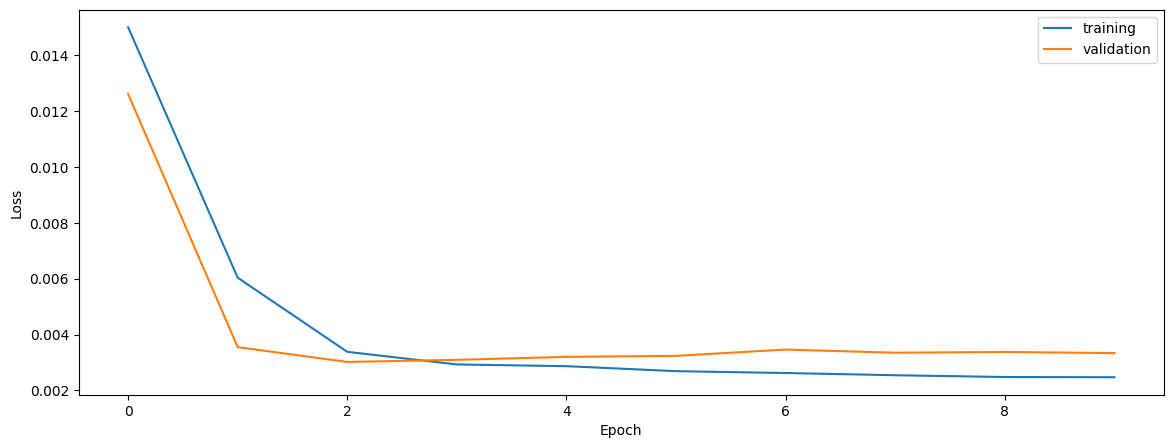

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.6126073009178127
0.6181728736209676
0.6299688502487331


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

native
0.6132740459053218
0.6179799582434619
0.632156061580729


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

normalized
0.6253963501365788
0.6401718035268954
0.661180522987439


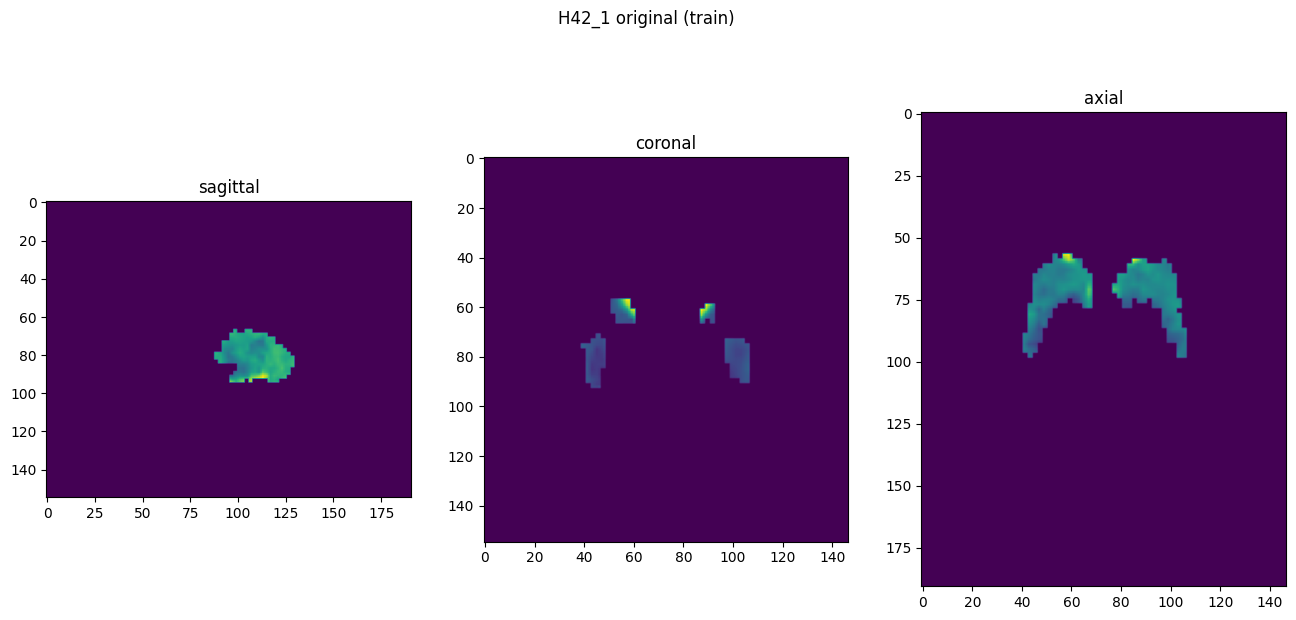

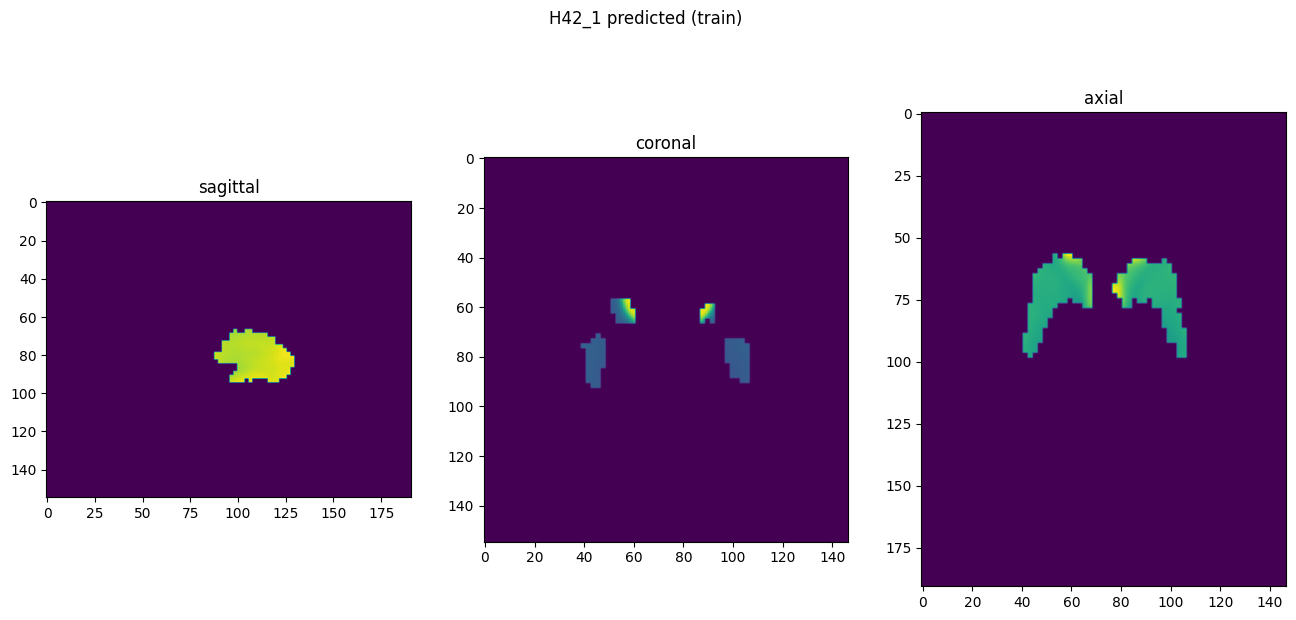

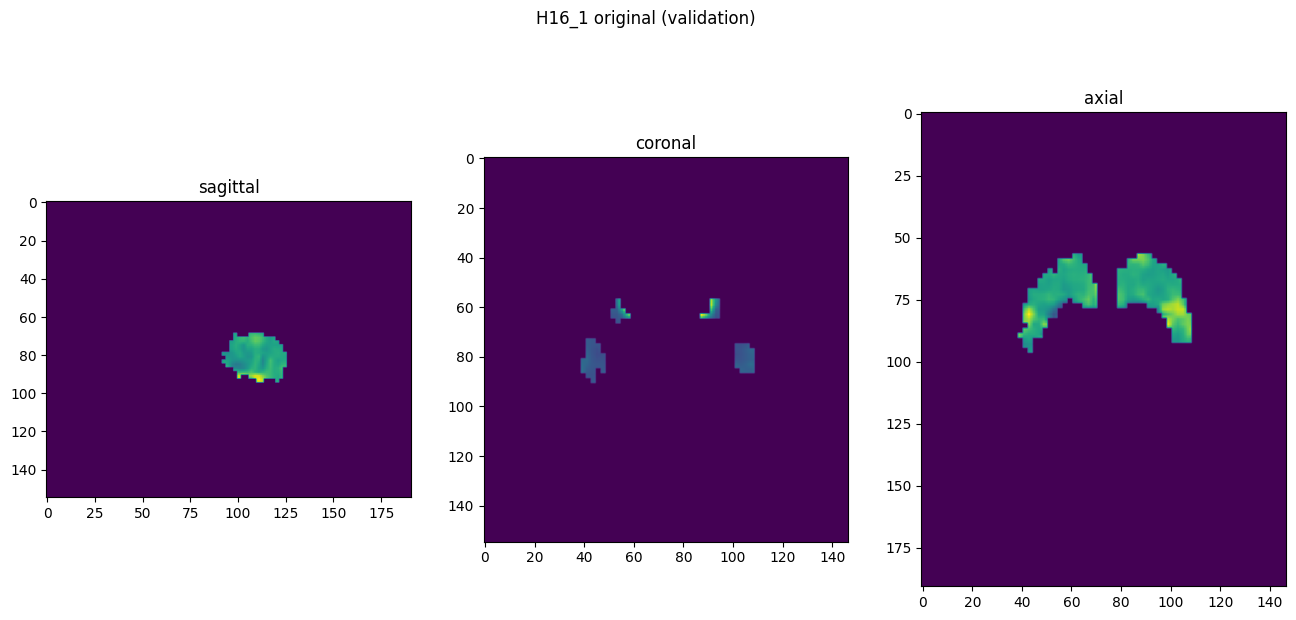

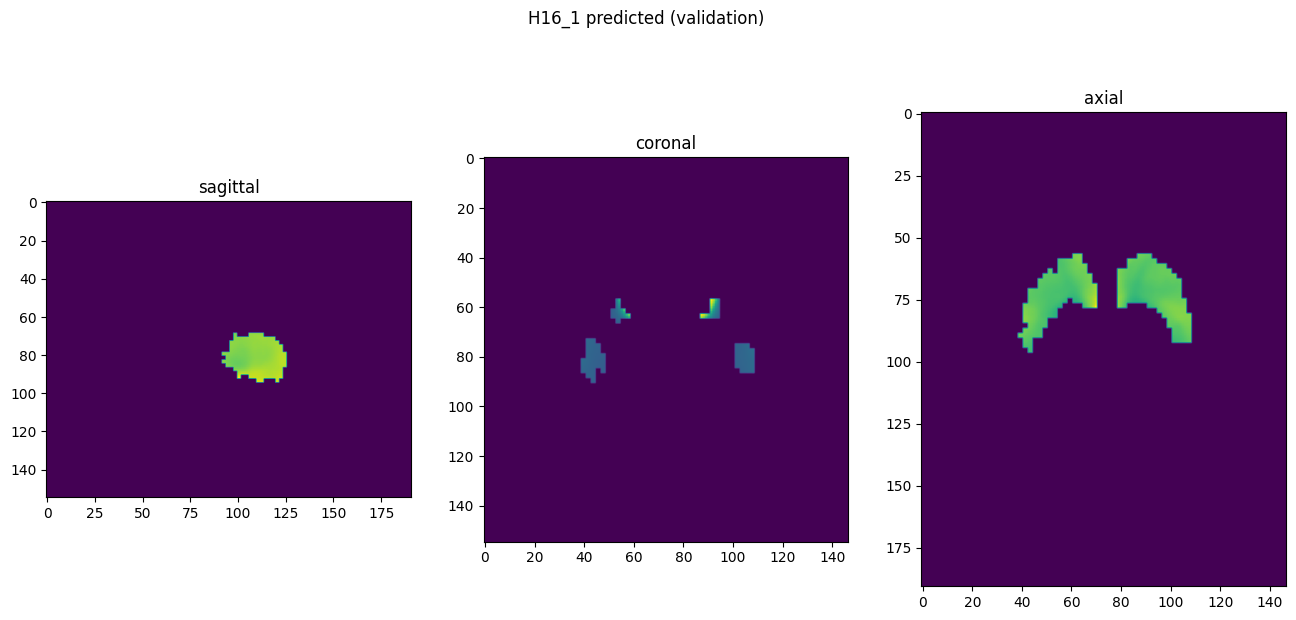

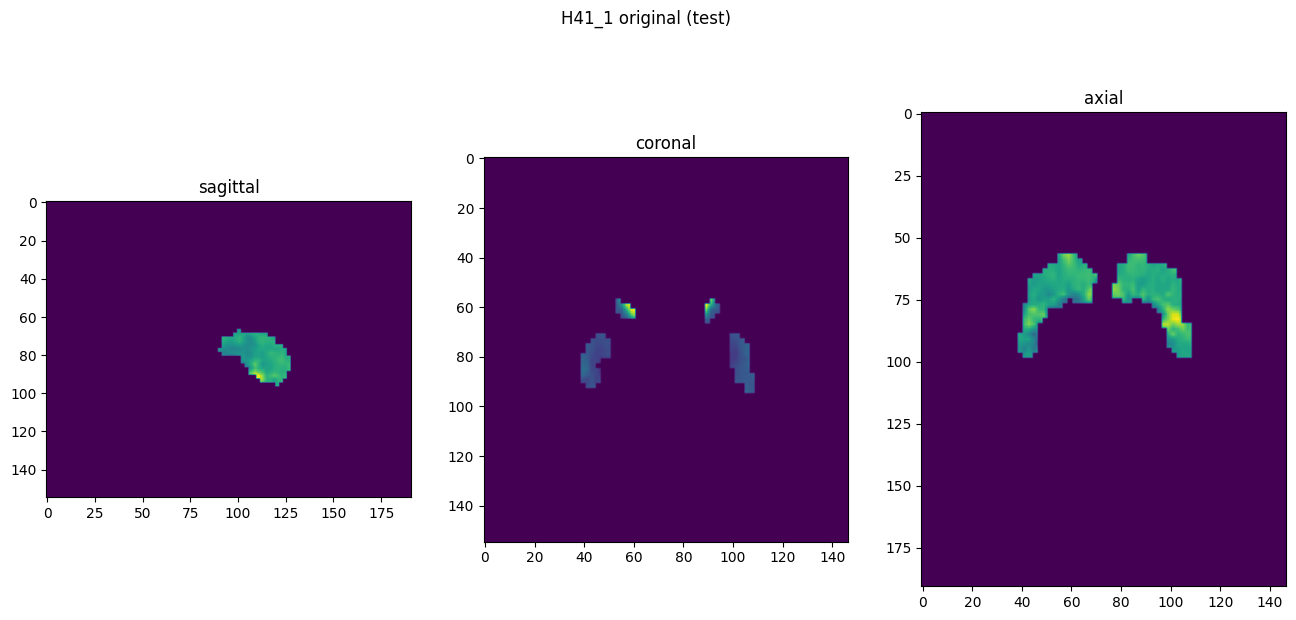

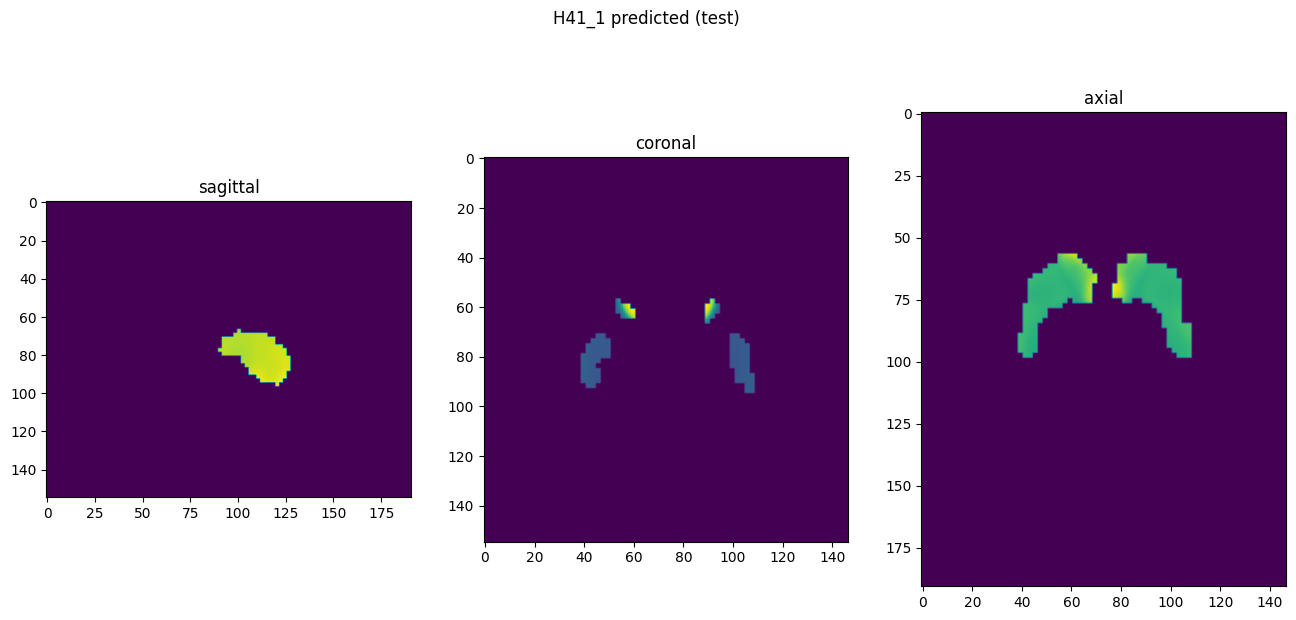

In [10]:
showResults(model, gen, threshold=None, background=False)